In [ ]:
%pip install sklearn
%pip transformers
%pip install huggingface
%pip install torch 
%pip install pandas
%pip install sklearn
%pip install datasets
%pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
ERROR: unknown command "transformers"
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 362 kB 12.0 MB/s 
     |████████████████████████████████| 1.1 MB 79.0 MB/s 
     |████████████████████████████████| 212 kB 74.8 MB/s 
     |████████████████████████████████| 140 kB 70.9 MB/s 
     |████████████████████████████████| 101 kB 11.7 MB/s 
     |████████████████████████████████| 596 kB 78.1 MB/s 
     |██████████████

In [ ]:
import pickle

#from sklearn.datasets import fetch_20newsgroups #encountered issues SSLCertificationError with this 
from datasets import load_dataset, load_metric
import os
import pandas as pd
import re
from bs4 import BeautifulSoup

from spacy import tokenizer
from spacy.lang.en import English
from sklearn.naive_bayes import GaussianNB, BernoulliNB,MultinomialNB
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import svm
import numpy as np


In [ ]:
#Methods
acc = load_metric('accuracy'); f1_score = load_metric('f1')

def parse_html(text):
    "removes hyperlink from a piece of text"
    
    soup = BeautifulSoup(text, "html.parser")
    parsed_text = soup.get_text()
    return parsed_text


def spacy_preproc(text):

    "Removes stopwords and punctuation and"
    nlp = English()
    tokenizer = nlp.tokenizer
    refined_text = tokenizer(text)
        
    refined_text = [text for text in refined_text if not text.is_stop]
    refined_text = [text for text in refined_text if not text.is_punct]
    refined_text = [text for text in refined_text if not text.like_email]
    refined_text = [text for text in refined_text if not text.like_url]
    refined_text = [text.text for text in refined_text if not text.like_num]

    text = " ".join(refined_text[:])

    return text

def regex_preproc(text): 

    refined_text = re.sub("(\n)", " ", text) #removes python newline 
    refined_text = re.sub("\w+(\')", "" , refined_text) #removes backslash
    refined_text = re.sub("(<\W+(p >))", " ", refined_text)
    refined_text = re.sub("(\s+)", " ", refined_text) #removes whitespaces
    #refined_text = re.sub("(&amp|>+|-+)", "", refined_text)
    #refined_text = re.sub("\W*(@)", "", refined_text) #removes emails 
    #refined_text = re.sub("(\d+)", "", refined_text) #removes digits

    return refined_text
                
def preproc(text):
  """Preprocesses files"""

  #output = parse_html(text)
  temp_output = spacy_preproc(text)
  final_output = regex_preproc(temp_output)

  return final_output


def prepare_corpus(path):
    """BY date"""
    corpus = {}; temp = []; 
    for topic in os.listdir(path):
        subfolder = path + '/' + topic
        current = []
        for doc in os.listdir(subfolder):
            file = subfolder + '/' + doc
            with open(file, 'r', encoding='utf-8', errors= 'ignore') as t:
               #corpus.append((preproc(" ".join(t.readlines())),topic),)
               temp = " ".join(t.readlines())
            current.append(temp)
        corpus[topic] = current
    return corpus


def extra_long_documents(text, chunk_size = 100):

  """
  Takes in a long documents chunks them into segments of lenght 'chunk_size'
  """
  doc_length = len(text); chunks = []
  
  if doc_length > chunk_size:
    output = range(doc_length//chunk_size)

    chunks = [text[:chunk_size*n] for n in output]
    last_index = output[-1]*chunk_size

    chunks.append(text[last_index:])
  else :
    chunks.append(text)
  
    return chunks 

def extract_features(text, min_df = 0.05 , max_df = 0.5, max_features = 1000, method = "Tfidf"):
    """Count represents the number of features to be chosen from tfidf while text represents text data
    vectorizer is either count_vectorizer or tfidfvectorizer"""
    
    if method.lower() == "tfidf":
        vectorizer = TfidfVectorizer(token_pattern = '[A-Za-z]+', min_df = float(min_df), max_df = float
                                     (max_df), ngram_range = (1,1), max_features = max_features)
    else:
        print("Wrong method. Choose between tfidf")

    vec = vectorizer.fit_transform(text)
    X_features = vectorizer.get_feature_names()
    print(vec.shape)
    return vec, X_features

#^\s

def accuracy(prediction, goldstandard):
    acc = 0
    for a,b in zip(prediction,goldstandard):
        if a == b:
            acc+=1
        else:pass
    return (acc/len(prediction))*100

def compute_metrics(predictions,label):

    f_1 = f1_score.compute(predictions = predictions, references = label, pos_label = 1)
    acc_1 = acc.compute(predictions = predictions, references = label)
    return acc_1['accuracy'], f_1['f1']


In [ ]:
hyperpartisan_dataset = load_dataset("hyperpartisan_news_detection", "bypublisher") #Not stripped of headers and footers
hyperpartisan_dataset.keys()

Extracting data files:   0%|          | 0/2 [00:00<?, ?it/s]

Extracting data files:   0%|          | 0/2 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/600000 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/600000 [00:00<?, ? examples/s]

Dataset hyperpartisan_news_detection downloaded and prepared to /root/.cache/huggingface/datasets/hyperpartisan_news_detection/bypublisher/1.0.0/7f4215b0474950ddf516e806400ab81d098b3da3b3a919a13cd1a4cf2c677012. Subsequent calls will reuse this data.


  0%|          | 0/2 [00:00<?, ?it/s]

dict_keys(['train', 'validation'])

In [ ]:
#change to bypublisher because byarticle has no test set.
hyperpartisan_train = hyperpartisan_dataset['train']
hyperpartisan_valid = hyperpartisan_dataset['validation']

hyperpartisan_train = hyperpartisan_train.shuffle(seed = 32)
hyperpartisan_valid = hyperpartisan_valid.shuffle(seed = 32)

In [ ]:
#If hyperpartisan use 1
#Else use 0
int_labels_train = [1 if x == True else 0 for x in hyperpartisan_train['hyperpartisan']]
int_labels_val = [1 if x == True else 0 for x in hyperpartisan_valid['hyperpartisan']]

In [ ]:
processed_train = [regex_preproc(parse_html(text)) for text in hyperpartisan_train["text"]]
processed_test = [regex_preproc(parse_html(text)) for text in hyperpartisan_train["text"]]

In [ ]:
with open('processed_train.pkl', "wb") as out:
  pickle.dump(processed_train, out)

with open('processed_test.pkl', "wb") as out_2:
  pickle.dump(processed_test, out_2)


In [ ]:
vec, feat = extract_features(processed_train, method = "tfidf")
vec.shape

(600000, 981)


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


(600000, 981)

In [ ]:
with open('features_mat_1000.pkl', "wb") as out:
  pickle.dump(vec, out)

In [ ]:
vec_test, feat_test = extract_features(hyperpartisan_valid['text'])

(600000, 1000)


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [ ]:
vec_test.shape

(600000, 1000)

In [ ]:
features = "features_mat_1000.pkl"
test_features = "features_mat_1000_test.pkl"

with open (features, 'rb') as ins:
  vec = pickle.load(ins)

with open(test_features, "rb") as test_in:
  vec_test = pickle.load(test_in)

In [ ]:
#Initialising multinomial naive bayes

mnb = {}; gnb = {} ; bnb = {}
num_of_features = [item for item in range(100, vec.shape[1], 100)]

for sub_set in num_of_features:
  MNB = MultinomialNB()
  BNB = BernoulliNB()
  GNB = GaussianNB()

  #Fitting features and output labels
  MNB.fit(vec[:,:sub_set],int_labels_train)
  BNB.fit(vec[:,:sub_set],int_labels_train)
  GNB.fit(vec[:,:sub_set].toarray(), int_labels_train)

  #assign test vector and predict 
  test_vec = vec_test[:,:sub_set]
  pred_mnb = MNB.predict(test_vec)
  pred_bnb = BNB.predict(test_vec)
  pred_gnb = GNB.predict(test_vec.toarray())

  #Score 
  mnb_acc, mnb_f1 = compute_metrics(pred_mnb, int_labels_val)
  mnb['acc'] = mnb.get('acc', []); mnb['f1'] = mnb.get('f1', [])
  mnb['acc'].append(mnb_acc); mnb['f1'].append(mnb_f1)

  bnb_acc, bnb_f1 = compute_metrics(pred_bnb, int_labels_val)
  bnb['acc'] = bnb.get('acc', []); bnb['f1'] = bnb.get('f1', [])
  bnb['acc'].append(bnb_acc); bnb['f1'].append(bnb_f1)

  gnb_acc, gnb_f1 = compute_metrics(pred_gnb, int_labels_val)
  gnb['acc'] = gnb.get('acc', []); gnb['f1'] = gnb.get('f1', [])
  gnb['acc'].append(gnb_acc); gnb['f1'].append(gnb_f1)


In [ ]:
mnb['acc']

[0.56871,
 0.58562,
 0.5791833333333334,
 0.5601483333333334,
 0.5577233333333333,
 0.5279116666666667,
 0.52252,
 0.5267666666666667,
 0.5193383333333333]

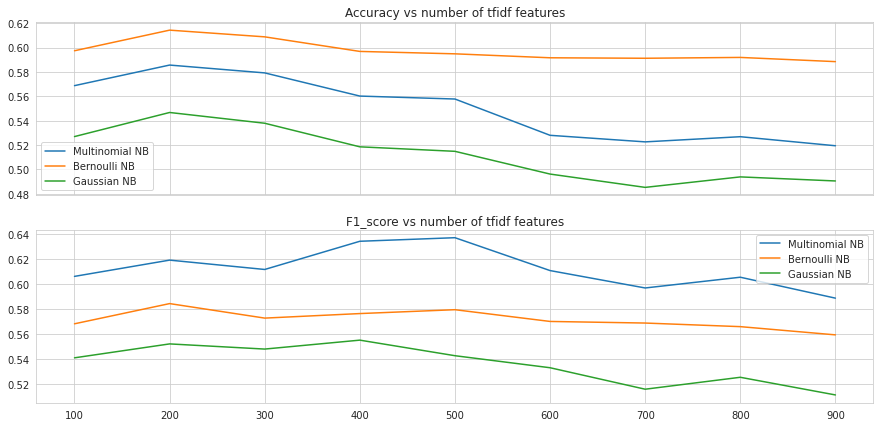

In [ ]:
from IPython.core.pylabtools import figsize
import seaborn as sns
import matplotlib.pyplot as plt 

sns.set_style("whitegrid")
sns.set_color_codes(palette = "deep")

fig,ax = plt.subplots(2,1, sharex = True, figsize = (15,7))

ax[0].plot(num_of_features,mnb['acc'])
ax[0].plot(num_of_features,bnb['acc'])
ax[0].plot(num_of_features,gnb['acc'])
ax[0].legend(['Multinomial NB', 'Bernoulli NB', 'Gaussian NB'], )
ax[0].title.set_text("Accuracy vs number of tfidf features")

plt.title("Naive Bayes vs number of features ")


ax[1].plot(num_of_features,mnb['f1'])
ax[1].plot(num_of_features,bnb['f1'])
ax[1].plot(num_of_features,gnb['f1'])
ax[1].title.set_text("F1_score vs number of tfidf features")
ax[1].legend(['Multinomial NB', 'Bernoulli NB', 'Gaussian NB'])
#ax[1].title("Naive Bayes vs number of features")

SVM

In [ ]:
acc_svc = [];

svc_classifier = svm.SVC(decision_function_shape='ovo')
svc_classifier.fit(vec[:,:],int_labels_train)

svc_prediction = svc_classifixer.predict(test_vec[:,:])
acc_svc.append(accuracy(svc_prediction, int_labels_val))

In [ ]:
plt.plot(acc_svc, num_of_features)